---
---





# Membuat Model NLP dengan TensorFlow

---

---

# Data Diri

Nama: Ridopandi Sinaga

E-mail: ridosinaga037@gmail.com

---

In [146]:

!wget --no-check-certificate \
  https://storage.googleapis.com/dataset-uploader/bbc/bbc-text.csv \
  -O /tmp/bbc-text.csv

--2023-06-21 21:09:32--  https://storage.googleapis.com/dataset-uploader/bbc/bbc-text.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.203.128, 172.253.123.128, 142.250.98.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5057493 (4.8M) [text/csv]
Saving to: ‘/tmp/bbc-text.csv’

/tmp/bbc-text.csv   100%[===================>]   4.82M  --.-KB/s    in 0.03s   

2023-06-21 21:09:32 (141 MB/s) - ‘/tmp/bbc-text.csv’ saved [5057493/5057493]



In [312]:
import pandas as pd
df = pd.read_csv('/tmp/bbc-text.csv')
df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   text      2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...
...,...,...
2220,business,cars pull down us retail figures us retail sal...
2221,politics,kilroy unveils immigration policy ex-chatshow ...
2222,entertainment,rem announce new glasgow concert us band rem h...
2223,politics,how political squabbles snowball it s become c...


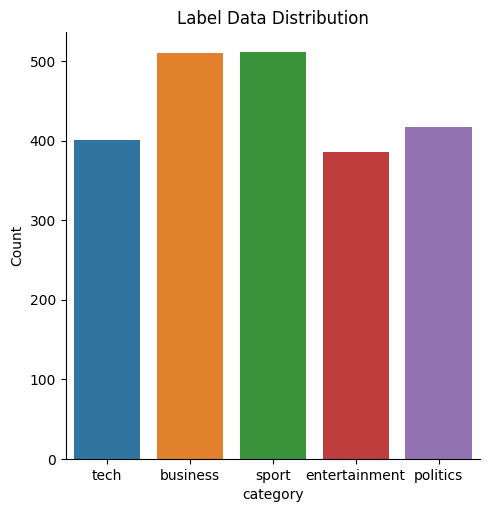

In [313]:
# Label Data Distribution/Proportion Graph
import seaborn as sns
import matplotlib.pyplot as plt

count = df['category'].value_counts()
sns.catplot(x='category', kind='count', data=df)
plt.title('Label Data Distribution')
plt.xlabel('category')
plt.ylabel('Count')
plt.show()

In [314]:
# Change the label into individual categories
# One hot encoding
category_ = pd.get_dummies(df['category'])
df_new   = pd.concat([df, category_], axis=1)
df_new   = df_new.drop(['category'], axis=1)
df_new

,text,business,entertainment,politics,sport,tech
0,tv future in the hands of viewers with home th...,0,0,0,0,1
1,worldcom boss left books alone former worldc...,1,0,0,0,0
2,tigers wary of farrell gamble leicester say ...,0,0,0,1,0
3,yeading face newcastle in fa cup premiership s...,0,0,0,1,0
4,ocean s twelve raids box office ocean s twelve...,0,1,0,0,0
...,...,...,...,...,...,...
2220,cars pull down us retail figures us retail sal...,1,0,0,0,0
2221,kilroy unveils immigration policy ex-chatshow ...,0,0,1,0,0
2222,rem announce new glasgow concert us band rem h...,0,1,0,0,0
2223,how political squabbles snowball it s become c...,0,0,1,0,0


In [315]:
# Lower case, and delete whitespace
import string
df_new['text'] = df_new['text'].str.lower().str.strip()

In [316]:
# Delete punctuation (tanda baca)
def removePunctuation(text):
    for punct in string.punctuation:
        text = text.replace(punct, ' ')
    return text

df_new['text'] = df_new['text'].apply(removePunctuation)

In [317]:
# Delete stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop = stopwords.words('english')

df_new['text'] = df_new['text'].apply(lambda x: ' '.join([
    word for word in x.split() if word not in (stop)
]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [319]:
# Seperate text and label values respectively in dataframe into numpy data type
tweet = df_new['text'].values
label = df_new[['business', 'entertainment', 'politics', 'sport', 'tech']].values

In [320]:
# Train and test data split
from sklearn.model_selection import train_test_split

descTrain, descTest, labelTrain, labelTest = train_test_split(tweet, label, test_size=0.2, random_state=1)

print(f'Train : {descTrain.shape} {labelTrain.shape}')
print(f'Test  : {descTest.shape} {labelTest.shape}')

Train : (1780,) (1780, 5)
Test  : (445,) (445, 5)


In [321]:
# Tokenizer sequence and padding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=5000, oov_token='x')
tokenizer.fit_on_texts(descTrain)
tokenizer.fit_on_texts(descTest)

sequenceTrain = tokenizer.texts_to_sequences(descTrain)
sequenceTest  = tokenizer.texts_to_sequences(descTest)

paddedTrain = pad_sequences(sequenceTrain, maxlen=100)
paddedTest  = pad_sequences(sequenceTest,  maxlen=100)

In [322]:
len(tokenizer.word_index)

29577

In [333]:
# Model architecture
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=16, input_length=100),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(5, activation='softmax')
])

model.compile(
    optimizer = 'adam',
    loss      = 'categorical_crossentropy',
    metrics   = ['accuracy']
)

model.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_26 (Embedding)    (None, 100, 16)           80000     
                                                                 
 bidirectional_10 (Bidirecti  (None, 100, 256)         148480    
 onal)                                                           
                                                                 
 global_max_pooling1d_10 (Gl  (None, 256)              0         
 obalMaxPooling1D)                                               
                                                                 
 dense_79 (Dense)            (None, 64)                16448     
                                                                 
 dense_80 (Dense)            (None, 32)                2080      
                                                                 
 dropout_11 (Dropout)        (None, 32)              

In [334]:
#Callback
class stopCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('accuracy') > 0.9 and logs.get('val_accuracy') > 0.9):
            print('\naccuracy and val_accuracy reach > 90%')
            self.model.stop_training = True

stopTraining = stopCallback()

reduceLROP   = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)

In [343]:
#train model
epoch = 30

history = model.fit(
    paddedTrain,
    labelTrain,
    batch_size      = 128,
    epochs          = epoch,
    steps_per_epoch = 10,
    validation_data = (paddedTest, labelTest),
    verbose         = 2,
    callbacks       = [reduceLROP]
)

Epoch 1/30
10/10 - 6s - loss: 0.1600 - accuracy: 0.9570 - val_loss: 0.6041 - val_accuracy: 0.8494 - lr: 9.9999e-41 - 6s/epoch - 642ms/step
Epoch 2/30
10/10 - 7s - loss: 0.1396 - accuracy: 0.9629 - val_loss: 0.6041 - val_accuracy: 0.8494 - lr: 9.9999e-41 - 7s/epoch - 671ms/step
Epoch 3/30
10/10 - 7s - loss: 0.1583 - accuracy: 0.9637 - val_loss: 0.6041 - val_accuracy: 0.8494 - lr: 9.9999e-41 - 7s/epoch - 705ms/step
Epoch 4/30
10/10 - 6s - loss: 0.1619 - accuracy: 0.9617 - val_loss: 0.6041 - val_accuracy: 0.8494 - lr: 9.9997e-42 - 6s/epoch - 577ms/step
Epoch 5/30
10/10 - 9s - loss: 0.1398 - accuracy: 0.9629 - val_loss: 0.6041 - val_accuracy: 0.8494 - lr: 9.9997e-42 - 9s/epoch - 866ms/step
Epoch 6/30
10/10 - 6s - loss: 0.1486 - accuracy: 0.9629 - val_loss: 0.6041 - val_accuracy: 0.8494 - lr: 1.0005e-42 - 6s/epoch - 639ms/step
Epoch 7/30
10/10 - 8s - loss: 0.1590 - accuracy: 0.9653 - val_loss: 0.6041 - val_accuracy: 0.8494 - lr: 1.0005e-42 - 8s/epoch - 770ms/step
Epoch 8/30
10/10 - 9s - los

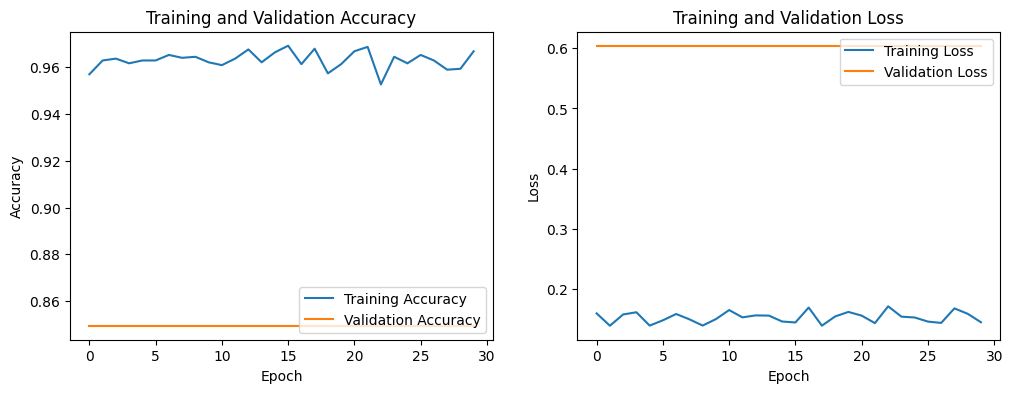

In [344]:
accuracy     = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss         = history.history['loss']
val_loss     = history.history['val_loss']

epoch_range  = range(epoch)

plt.figure(figsize = (12, 4))
plt.subplot(1, 2, 1)
plt.plot(epoch_range, accuracy,     label='Training Accuracy')
plt.plot(epoch_range, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(epoch_range, loss,     label='Training Loss')
plt.plot(epoch_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()

In [337]:
loss, accuracy = model.evaluate(paddedTest, labelTest)
print('Accuracy:', accuracy)

14/14 [==============================] - 1s 79ms/step - loss: 0.6041 - accuracy: 0.8494
Accuracy: 0.8494381904602051
